# Eclipsing binary with `pymc3`

Let's fit an eclipsing binary light curve with `starry`, using `pymc3` to get posterior constraints on the map.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
np.random.seed(12)

## Instantiate two bodies

The primary is an unspotted solar-like star with quadratic limb darkening. Note that since we're going to use these maps below in the `pymc3` run, we declare it within the context of a `pymc3.Model()` instance.

In [3]:
with pm.Model() as model:
    A = starry.Primary(starry.Map(udeg=2, L=1.0), r=1.0, m=1.0)
    A.map[1] = 0.40
    A.map[2] = 0.25

A.map.show(theta=np.linspace(0, 360, 50))

Compiling `render`... Done.


The secondary is a smaller star (say, a K dwarf) on a very short period orbit with a large mid-latitude spot. To make things interesting, its rotation period is resonant with its orbital period at 5:8. Its equator is coplanar with the orbit, but the entire system is viewed at an inclination of $75^\circ$. Since the orbital period is so short, there are both grazing primary and secondary eclipses.

In this notebook, we will attempt to infer the map of this star. Note again that we define it within the context of `model`:

In [7]:
with model:
    B = starry.Secondary(
            starry.Map(
                ydeg=5,
                inc=75.0,
                L=0.1
            ),
            r=0.7,
            m=0.7,
            porb=1.00,
            prot=0.625,
            t0=0.15,
            inc=75.0
        )
    B.map.add_spot(amp=-0.075, lat=-30, lon=60)

B_true_map = B.map[1:, :].eval()
B.map.show(theta=np.linspace(0, 360, 50))

Compiling `render`... Done.


Even with occultations, there are significant degeneracies in the mapping problem, so we need a good prior. Let's assume we have some information about the power spectrum of the star, which is the sum of the squares of the spherical harmonic coefficients at each degree.

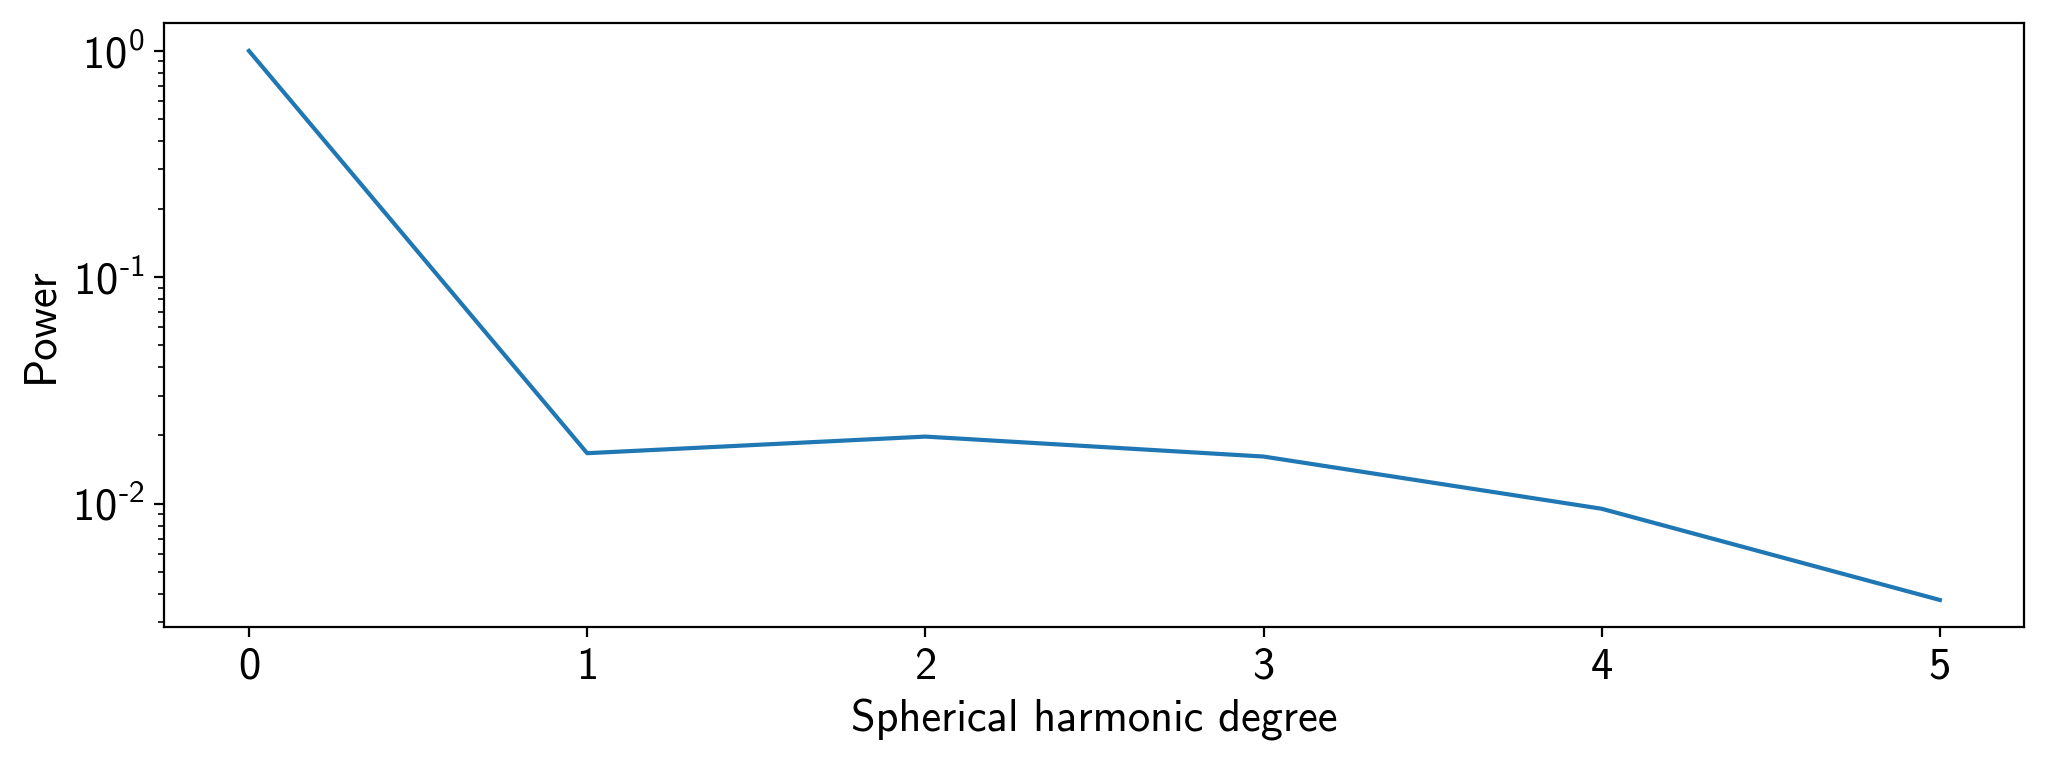

In [8]:
plt.plot([np.sum(B.map[l, :].eval() ** 2) for l in range(B.map.ydeg + 1)])
plt.yscale("log")
plt.xlabel("Spherical harmonic degree")
plt.ylabel("Power");

The power is (very) roughly flat at $10^{-2}$ for $l>0$, so that will be the **variance** on the Gaussian prior on the spherical harmonic coefficients.

## Generate a light curve

Let's generate a synthetic light curve for the system over several days.

In [9]:
with model:
    sys = starry.System(A, B)
    
# Compute the light curve    
t = np.linspace(-2.5, 2.5, 10000)
flux_true = sys.flux(t).eval()

# Add noise
sigma = 0.00025
flux = flux_true + sigma * np.random.randn(len(t))

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


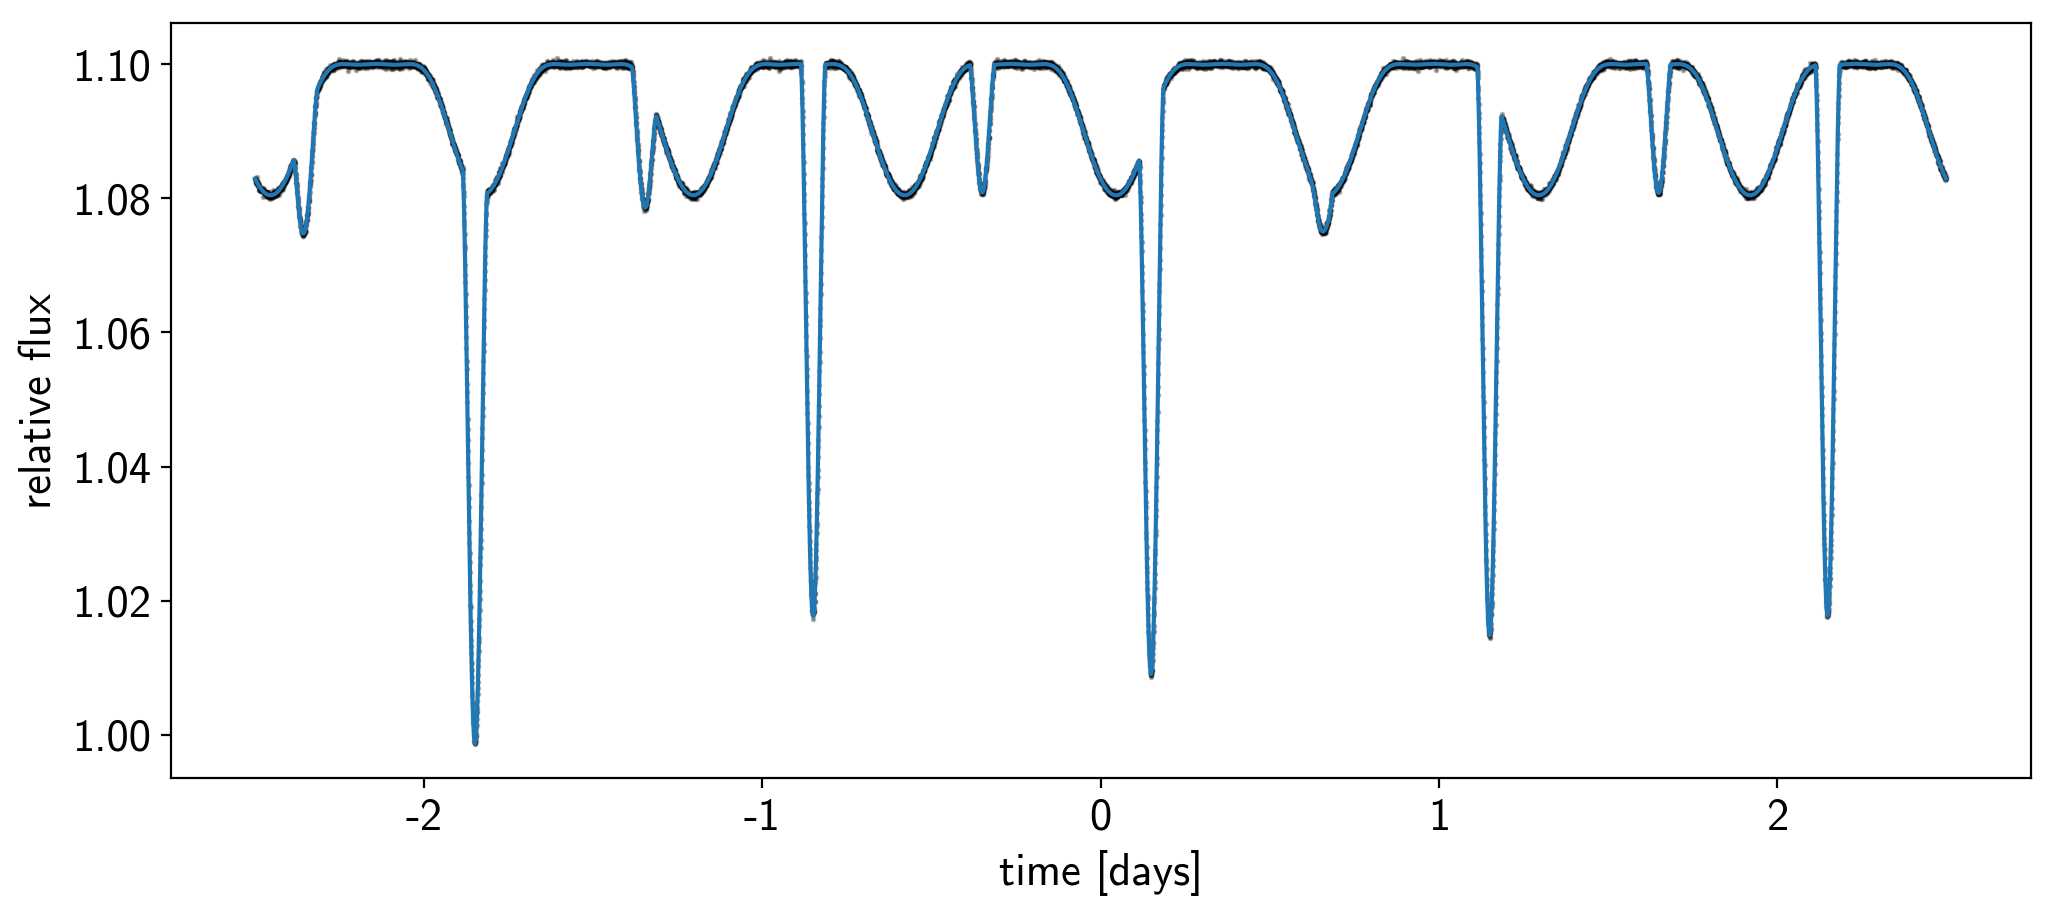

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, 'k.', alpha=0.3, ms=2)
ax.plot(t, flux_true)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux");

We can visualize the orbit over this time period. Note that we get a few occultations of the front side and a few occultations of the back side of the secondary, which means we'll be able to constrain most of its surface!

In [8]:
sys.show(t=np.linspace(-2.5, 2.5, 300), window_pad=4.75, figsize=(5, 5))

## Let's define the `pymc3` model

Here we define the model and our priors; recall that we are placing a zero-mean Gaussian prior on the spherical harmonic coefficients with variance equal to $10^{-2}$. Also note that we don't fit for the zeroth spherical harmonic coefficient ($Y_{0,0}$), as that is always fixed at unity. For simplicity, we assume we know everything else about the system.

In [9]:
with model:

    # The Ylm coefficients with a simple gaussian prior
    ncoeff = B.map.Ny - 1
    mu = np.zeros(ncoeff)
    cov = 1e-2 * np.eye(ncoeff)
    Ylm = pm.MvNormal("Ylm", mu, cov, shape=(ncoeff,))
    B.map[1:, :] = Ylm
    
    # Compute the flux
    flux_model = sys.flux(t=t)
    
    # Track some values for plotting later
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = xo.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=sigma, observed=flux)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Now we run a quick gradient descent to find the MAP (maximum a posteriori) solution. This will give us a decent starting point for the inference problem.

In [10]:
with model:
    map_soln = xo.optimize()

optimizing logp for variables: ['Ylm']
0it [00:00, ?it/s]/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
81it [00:01, 61.77it/s, logp=6.886503e+04]  
message: Optimization terminated successfully.
logp: -4139782.0785725648 -> 68865.03399369546


Plot the MAP model alongside the initial guess and the true model. Note that we're doing quite well.

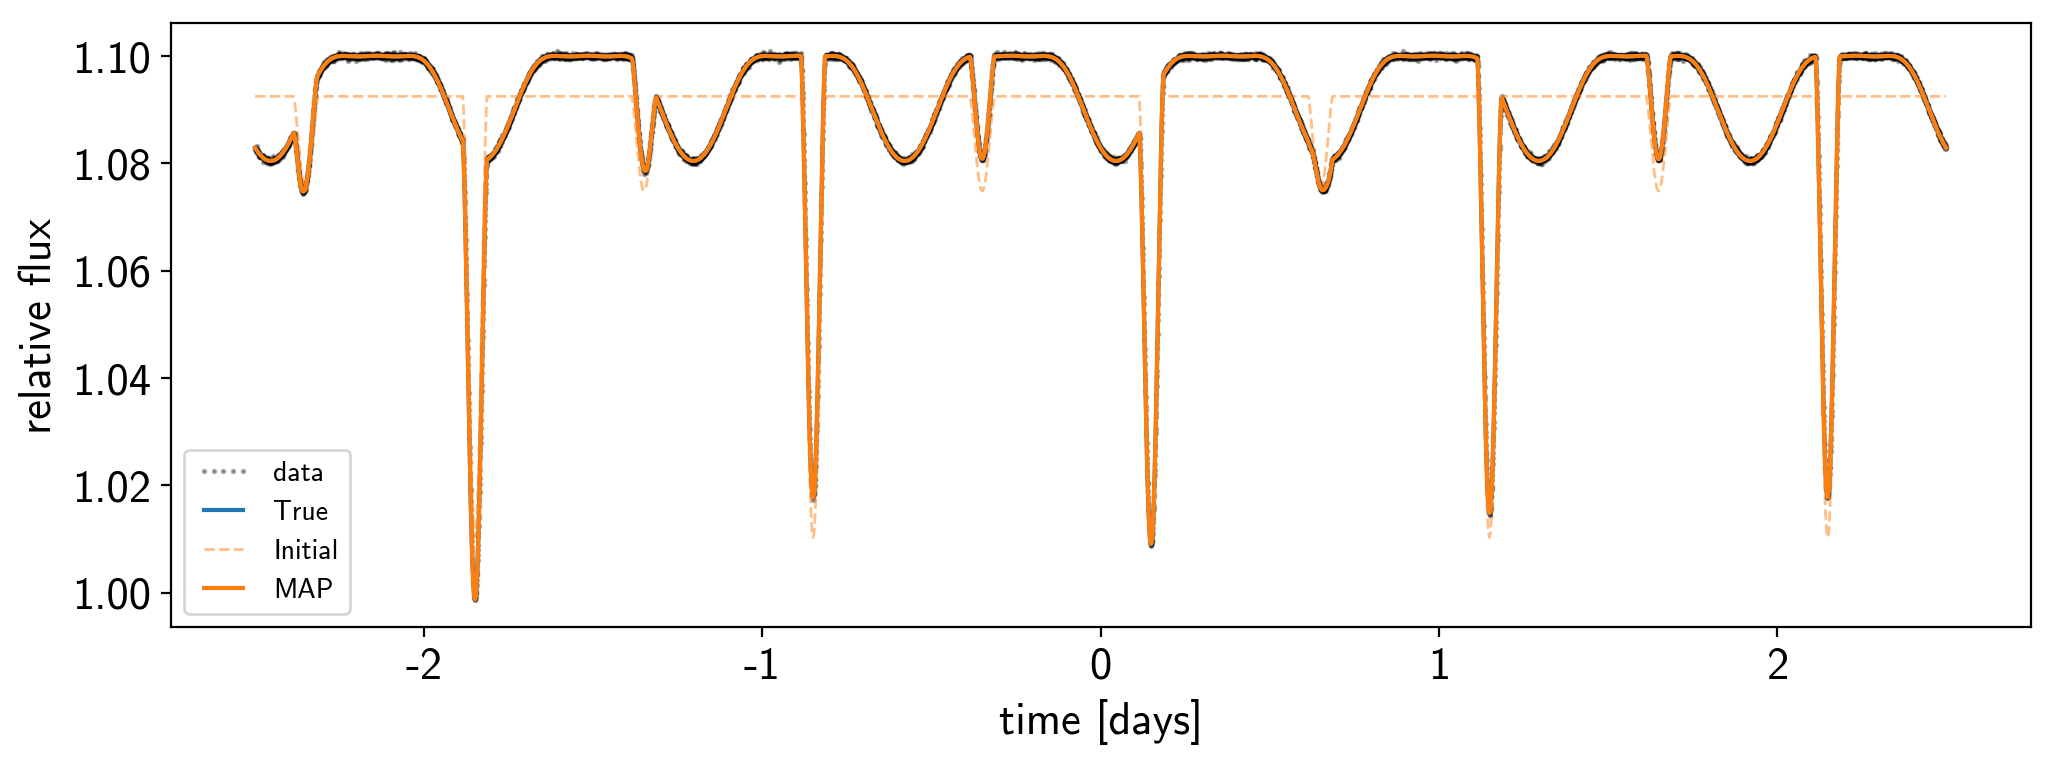

In [11]:
plt.plot(t, flux, 'k.', alpha=0.3, ms=2, label="data")
plt.plot(t, flux_true, "C0-", label="True")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(t, xo.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP")
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]")
plt.ylabel("relative flux");

Plot the corresponding map for `B`: note that we recover the spot!

In [12]:
map = starry.Map(ydeg=5)
map.inc = 75
map[1:, :] = map_soln['Ylm']
map.show(theta=np.linspace(0, 360, 50))

Compiling `render`... Done.


## NUTS sampling

Now let's run the NUTS sampler to get posteriors on the map of `B`.

In [13]:
%%time
sampler = xo.PyMC3Sampler(window=100, finish=200, cores=1)
with model:
    burnin = sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 202/202 [00:13<00:00, 14.45it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [Ylm]
100%|██████████| 2000/2000 [01:27<00:00, 22.86it/s]


CPU times: user 1h 44min 49s, sys: 1min 18s, total: 1h 46min 8s
Wall time: 17min 52s


Things appear to have converged well:

In [14]:
varnames = ["Ylm"]
pm.summary(trace, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Ylm__0,0.057563,0.051007,0.000533,-0.039953,0.158725,7352.111261,0.999821
Ylm__1,-0.053813,0.010468,0.000115,-0.074466,-0.033147,8852.325743,0.999778
Ylm__2,-0.096536,0.009970,0.000119,-0.115962,-0.076768,7689.378152,0.999888
Ylm__3,0.092260,0.034674,0.000422,0.026339,0.161381,7709.702842,0.999811
Ylm__4,0.044753,0.035955,0.000402,-0.027832,0.113708,8967.559057,0.999758
Ylm__5,0.035585,0.035157,0.000363,-0.034612,0.102442,7365.669619,0.999843
Ylm__6,-0.077408,0.004867,0.000054,-0.087105,-0.068303,8433.167173,1.000000
Ylm__7,-0.028063,0.060391,0.000636,-0.147104,0.088805,7336.304917,0.999808
Ylm__8,0.058779,0.058938,0.000622,-0.057854,0.170005,6948.452352,0.999898
Ylm__9,0.070930,0.036731,0.000406,0.000360,0.142445,8354.696614,1.000026


Display the corner plot for a few of the dimensions. Note the strong degeneracies that are still present.

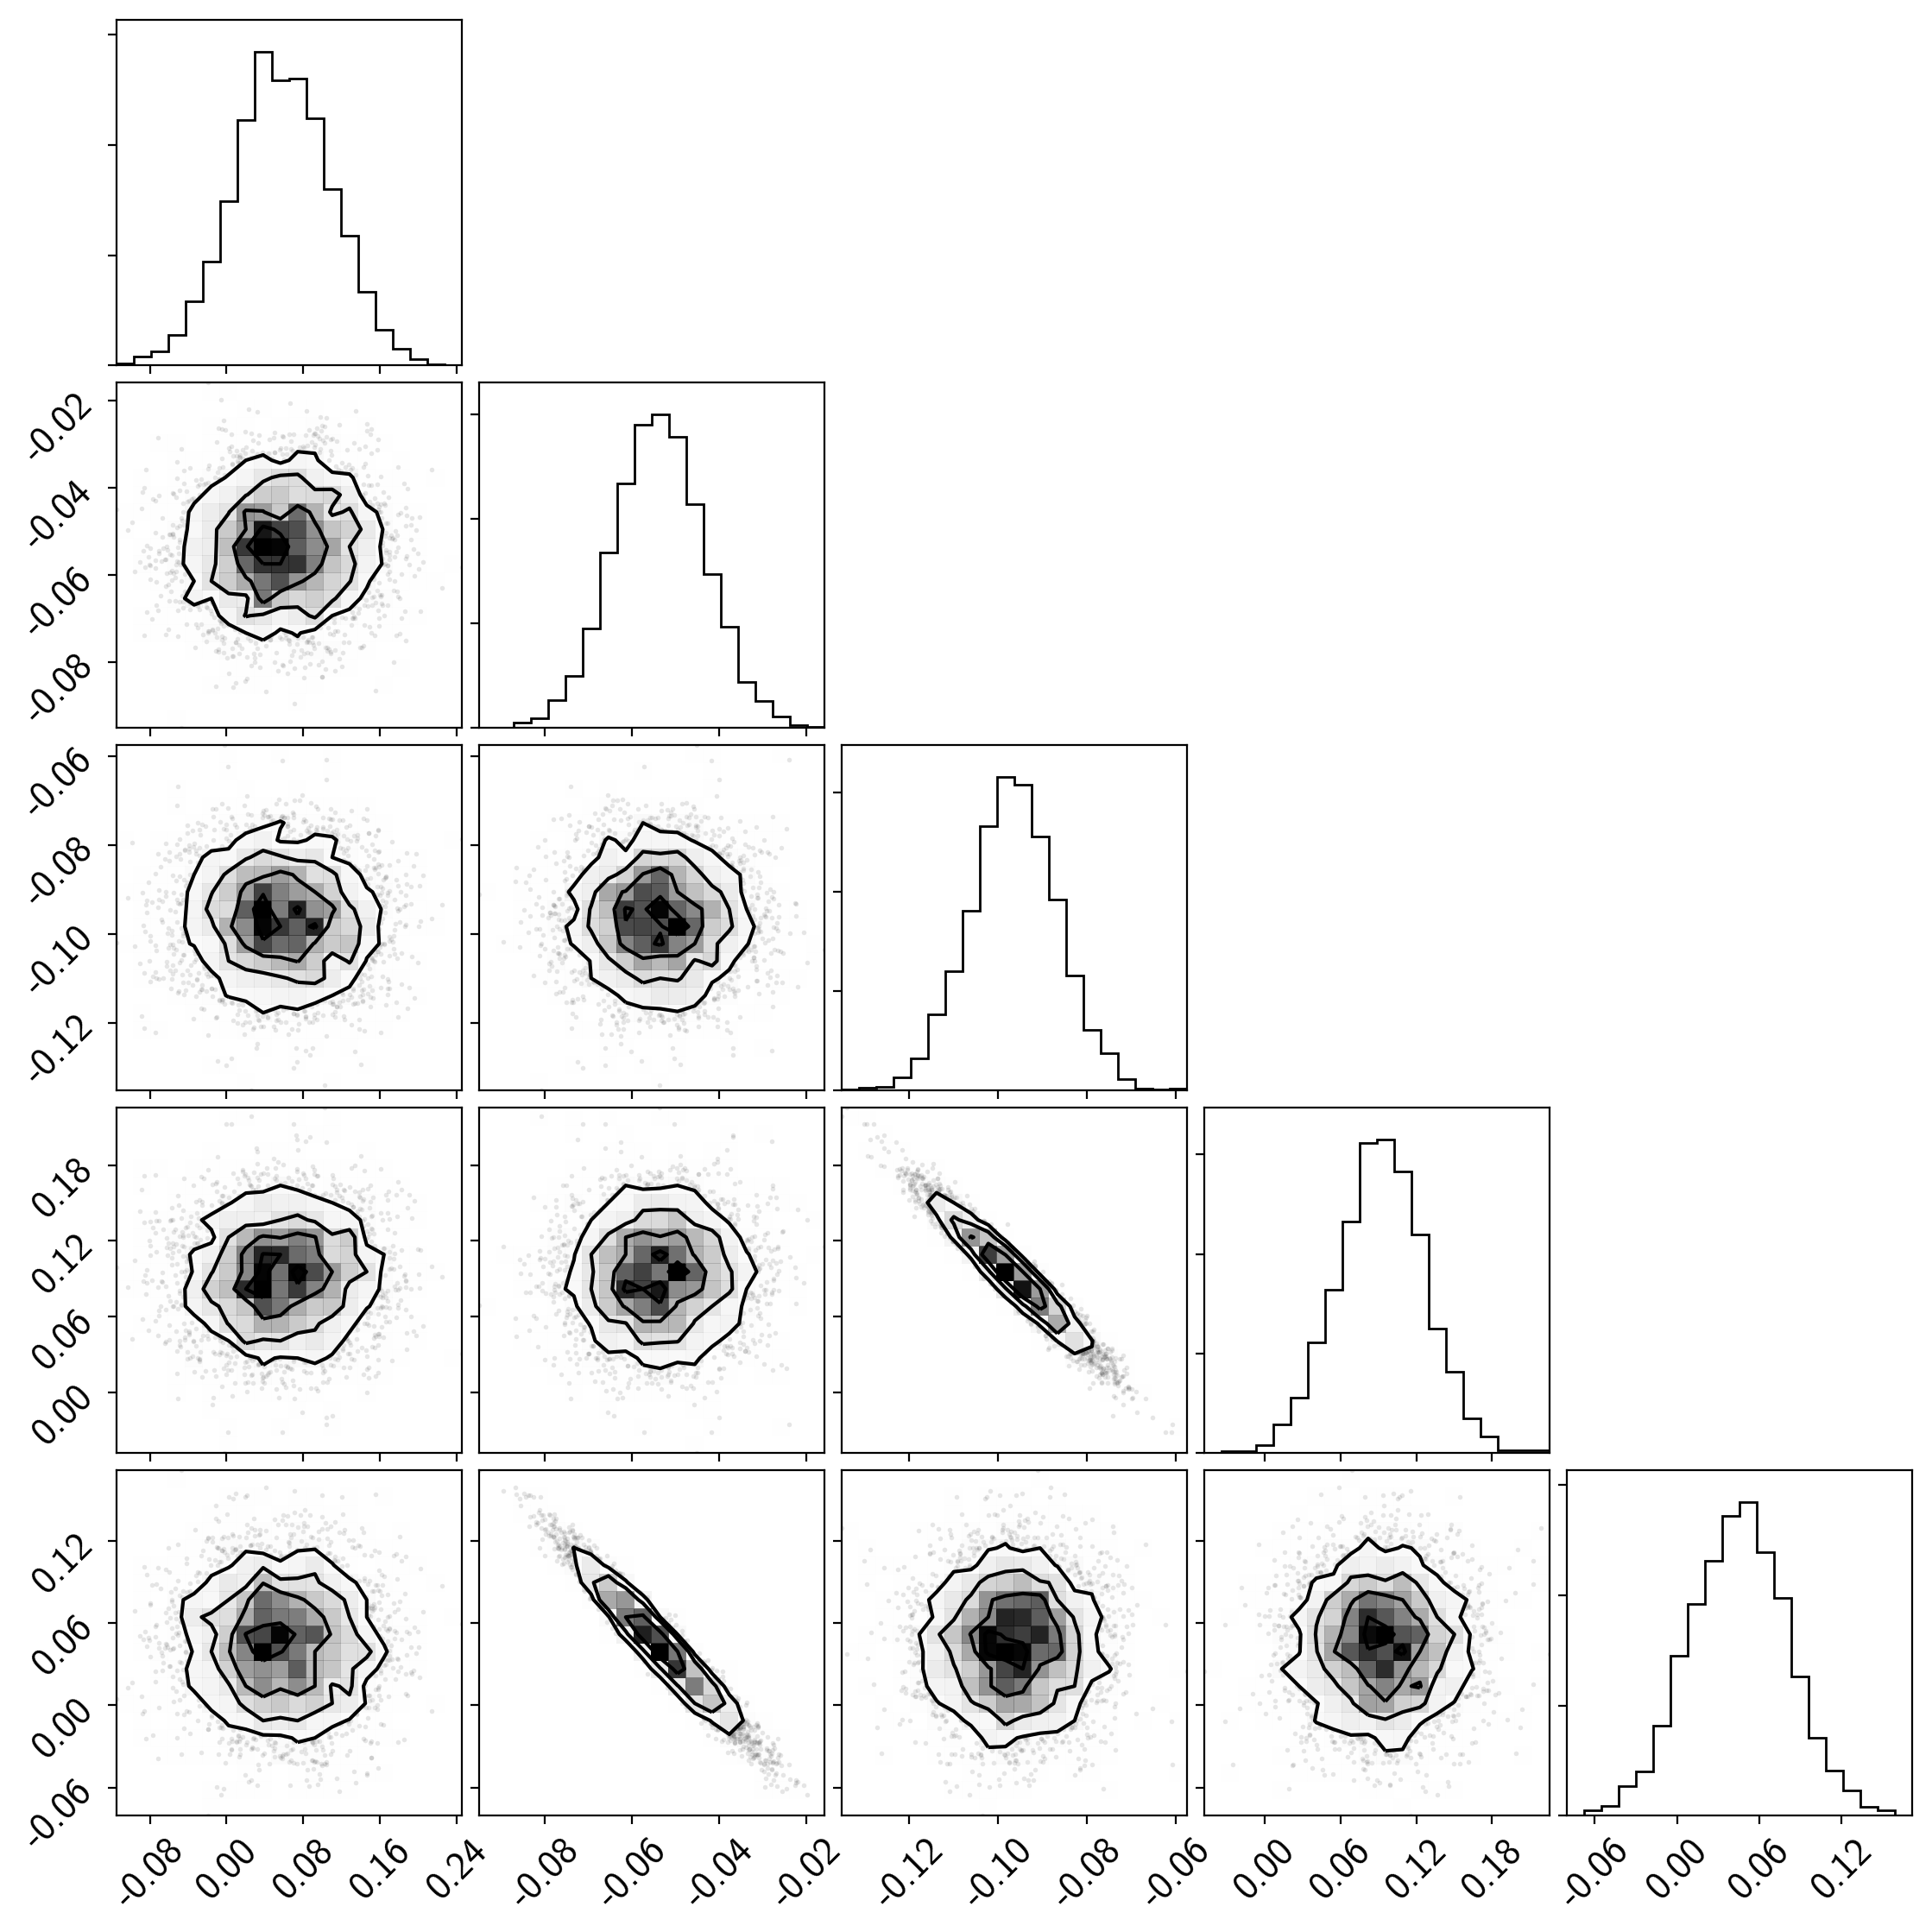

In [15]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(np.array(samples)[:, :5]);

Plot the model for 24 random samples:

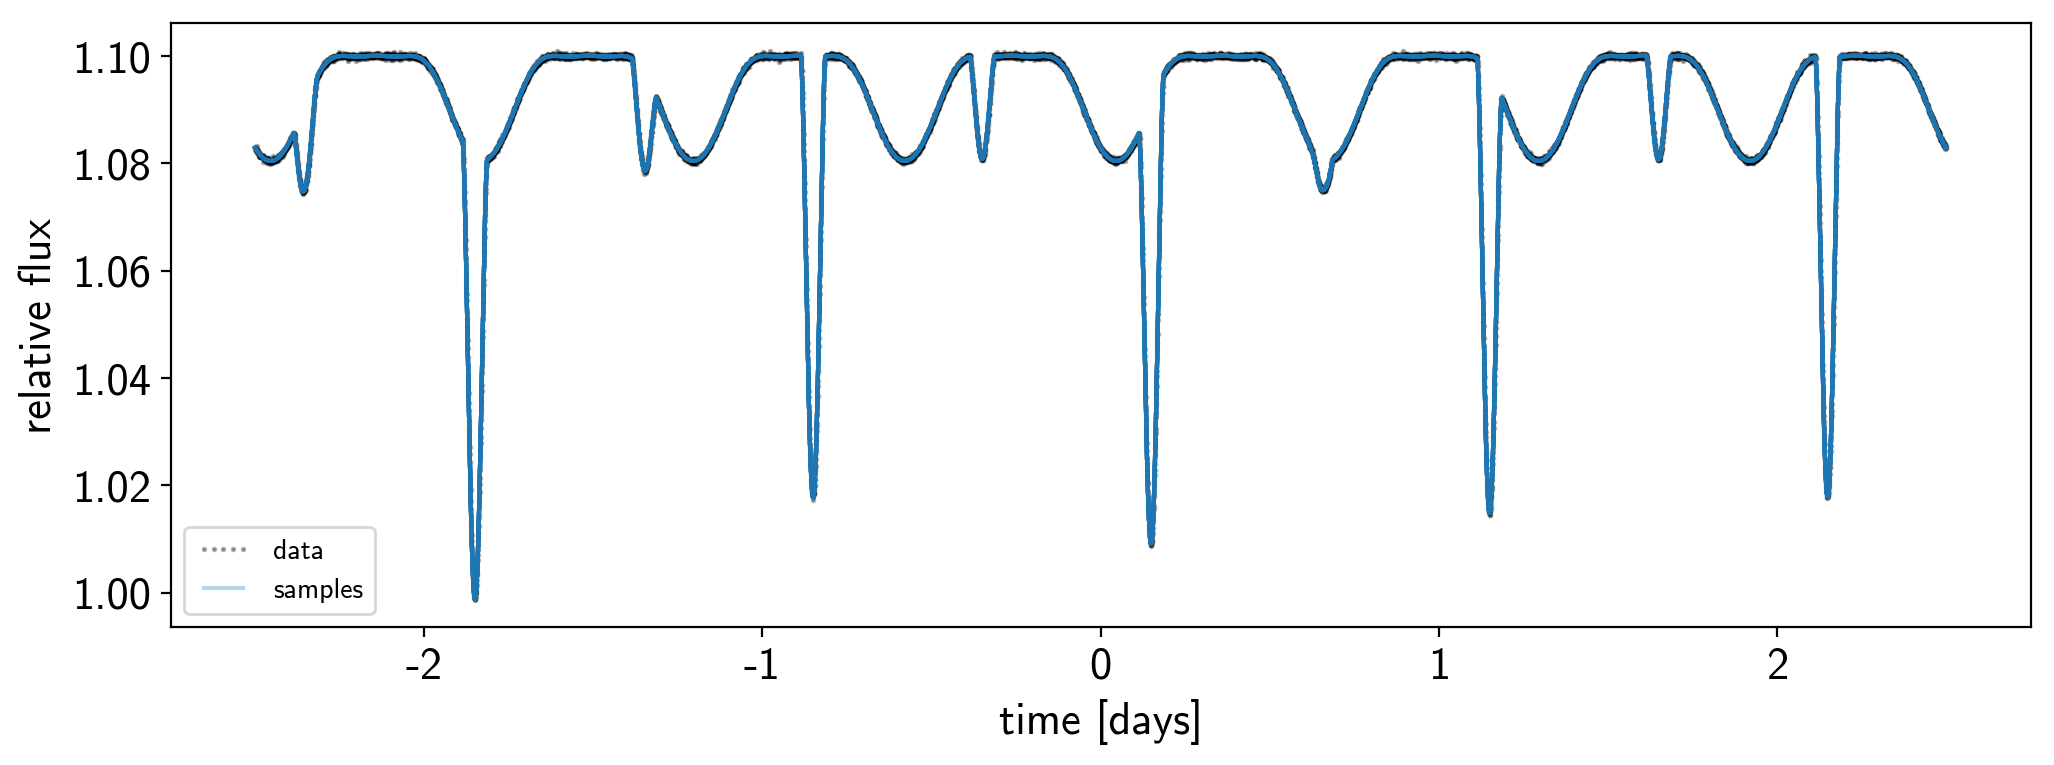

In [16]:
plt.plot(t, flux, 'k.', alpha=0.3, ms=2, label="data")
label = "samples"
for i in np.random.choice(range(len(trace["flux_model"])), 24):
    plt.plot(t, trace["flux_model"][i], "C0-", alpha=0.3, label=label)
    label = None
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]")
plt.ylabel("relative flux");

Finally, display the true map next to several random samples:

In [36]:
# Render the true map and 17 samples
nframes = 100
nsamp = len(trace["Ylm"])
coeffs = [B_true_map] + [trace["Ylm"][np.random.randint(nsamp)] for i in range(17)]
img = [None for i in range(18)]
for i, coeff in enumerate(coeffs):
    map[1:, :] = coeff
    img[i] = map.render(theta=np.linspace(0, 360, nframes)).eval()

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(6, 3, figsize=(4, 8))
ax = ax.flatten()
ims = [None for i in range(18)]
for i in range(18):
    ims[i] = ax[i].imshow(img[i][0], origin="lower", vmin=0, vmax=0.45, cmap="plasma")
    ax[i].axis('off')

def updatefig(k):
    for i in range(18):
        ims[i].set_data(img[i][k])
    return ax

ani = FuncAnimation(fig, updatefig, interval=30, blit=False, frames=nframes)
plt.close()

In [42]:
display(HTML(ani.to_html5_video()))